**READ.ME**

This file helps you explore the functions of Brightway 2.5 in an intuitive way. So far, we have linked a background database with a simple foreground model in the previous sections of this repository.

It is not a tutorial to go through, but a collection of usable code which you can adapt for your own projects. The goal is to make Brightway 2.5 easy to use for your own projects. Any contribution to this overview is welcome.


## 🌍 Brightway 2.5 - Quick Exploration Guide

Before analyzing a Brightway model, ensure all required packages, databases, and projects are installed. These have already been set up in other scripts in this repository, so we can call them directly from the project folder stored in Brightway without re-importing or re-matching background databases.

### ⚙️ Step 1: Load Your Project

After ensuring all necessary packages are installed, you call the same project where you have installed and imported your databases. This happens through `bd.projects.set_current('LCA_Toolbox')`



In [1]:
# basic packages from brightway
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
from bw2io.importers import SingleOutputEcospold2Importer
import bw2analyzer as bwa
from bw2data import methods

# other relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [2]:
# call the project we want to work in, in this case brightway25 where we have set up the databases
bd.projects.set_current('LCA_Toolbox')

### ⚙️ Step 2: Database overview

This section provides an overview of the background and foreground databases stored in the Brightway project.

In [3]:
bd.databases

Databases dictionary with 4 object(s):
	biosphere3
	bw25_db
	ecoinvent-3.10-biosphere
	ecoinvent310clca

In [4]:
bd.projects.current

'LCA_Toolbox'

In [5]:
ei_clca = bd.Database('ecoinvent310clca')
ei_bio = bd.Database('ecoinvent-3.10-biosphere')
db_template = bd.Database('bw25_db')
el_bio3 = bd.Database('biosphere3')

#### 🔍 Step 3: Searching the Database

Use the following `database.search('')` function to search for entries in your database

In [6]:
# search for activities in the database
db_template.search('ceramics')

['porcelain ceramics production' (kilogram, RER, None)]

In [34]:
ei_clca.search('ammonia production')

['ammonia production, steam reforming, liquid' (kilogram, CN, None),
 'ammonia production, steam reforming, liquid' (kilogram, RNA, None),
 'ammonia production, steam reforming, liquid' (kilogram, RAF, None),
 'ammonia production, steam reforming, liquid' (kilogram, RER w/o RU, None),
 'ammonia production, steam reforming, liquid' (kilogram, RLA, None),
 'ammonia production, steam reforming, liquid' (kilogram, UN-OCEANIA, None),
 'ammonia production, steam reforming, liquid' (kilogram, UN-SEASIA, None),
 'ammonia production, steam reforming, liquid' (kilogram, SAS, None),
 'ammonia production, steam reforming, liquid' (kilogram, RU, None),
 'ammonia production, partial oxidation, liquid' (kilogram, CN, None),
 'ammonia production, partial oxidation, liquid' (kilogram, RoW, None),
 'ammonia production, steam reforming, liquid' (kilogram, RoW, None),
 'urea production' (kilogram, RER, None),
 'urea production' (kilogram, CN, None),
 'urea production' (kilogram, RNA, None),
 'nutrient sup

In [8]:
# select a random activity from the database
ei_clca.random()

'market for waste wood, untreated' (kilogram, BA, None)

#### 🧾 Step 4: Select a Process & Check Inventory

`define_name = database.get(name='', location='', unit='')` assigns the object "define_name" to the entry in the database that matches the search criteria.
    
You can directly export the inventory of the defined process to an Excel overview through `bi.export.excel.write_lci_excel(database.name, objs=[define_name], dirpath=Path.cwd())`.

    

In [35]:
# define a process and store in a object in the project
ceramics_bw = db_template.get(name = 'porcelain ceramics production', location = "RER", unit = 'kilogram')
ceramics_ei = ei_clca.get(name = 'sanitary ceramics production', location = "CH", unit = 'kilogram')

blasting = ei_clca.get(name = 'abrasive blasting, alumina, carbon steel substrate', location = "GLO", unit = 'square meter')

ammonia = ei_clca.get(name = 'ammonia production, steam reforming, liquid', location = "RER w/o RU", unit = 'kilogram')

In [36]:
# export the LCI to Microsoft Excel in an overview format
bi.export.excel.write_lci_excel(ei_clca.name, objs=[ammonia], dirpath=Path.cwd())

'c:\\Users\\TimWeber\\repos_20LCA\\LCA_Toolbox\\lci-ecoinvent310clca.xlsx'

In [11]:
# print the outputs of the process
list(ceramics_ei.production())

[Exchange: 1.0 kilogram 'sanitary ceramics production' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>]

In [12]:
# print the consumers of a product
list(ceramics_ei.consumers())


[Exchange: 0.00841688555967824 kilogram 'sanitary ceramics production' (kilogram, CH, None) to 'market for sanitary ceramics' (kilogram, GLO, None)>]

In [13]:
# (1) this is a way to print all exchanges of a process, there are multiple ways to extract this information
list(ceramics_ei.edges())


[Exchange: 1.0 kilogram 'sanitary ceramics production' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: -0.000177 kilogram 'market for bilge oil' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 4e-09 unit 'ceramic factory construction' (unit, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.00303 kilogram 'market for chemical, inorganic' (kilogram, GLO, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.425 kilogram 'market for clay' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.878 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.379 kilogram 'market for feldspar' (kilogram, GLO, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: -0.000102 kilogram 'market for hazardous waste, for un

In [14]:
# (2) this is an other way to print all exchanges of a process
exchanges = sorted(ceramics_ei.exchanges(), key=lambda exc: exc['amount'], reverse=True)
for exc in exchanges:
    print(exc)

Exchange: 22.895 megajoule 'market for heat, district or industrial, natural gas' (megajoule, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 1.0 kilogram 'sanitary ceramics production' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 0.878 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 0.541 kilogram 'market for tap water' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 0.444 kilogram 'market for kaolin' (kilogram, GLO, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 0.425 kilogram 'market for clay' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 0.379 kilogram 'market for feldspar' (kilogram, GLO, None) to 'sanitary ceramics production' (kilogram, CH, None)>
Exchange: 0.251 kilogram 'market for silica sand' (kilogram, GL

In [15]:
# (3) Alternative way to display all exchanges with the technosphere
list(ceramics_ei.technosphere())


[Exchange: -0.000177 kilogram 'market for bilge oil' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 4e-09 unit 'ceramic factory construction' (unit, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.00303 kilogram 'market for chemical, inorganic' (kilogram, GLO, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.425 kilogram 'market for clay' (kilogram, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.878 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, CH, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 0.379 kilogram 'market for feldspar' (kilogram, GLO, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: -0.000102 kilogram 'market for hazardous waste, for underground deposit' (kilogram, RER, None) to 'sanitary ceramics production' (kilogram, CH, None)>,
 Exchange: 22.895 megajoule 'market

### 🌿 Step 4: Impact Assessment Methods

To calculate the Life Cycle Impacts the back- and foreground need to be linked to an assessment method. There is a large number of available methods that are pre-installed together with the ecoinvent biosphere flows in the 01_bw25_ecoinvent_importer script.

In [17]:
# here we will analyse the set of methods that are available as part of the background
list(bd.methods)[:5]

[('CML v4.8 2016 no LT',
  'acidification no LT',
  'acidification (incl. fate, average Europe total, A&B) no LT'),
 ('CML v4.8 2016 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('CML v4.8 2016 no LT',
  'ecotoxicity: freshwater no LT',
  'freshwater aquatic ecotoxicity (FAETP inf) no LT'),
 ('CML v4.8 2016 no LT',
  'ecotoxicity: marine no LT',
  'marine aquatic ecotoxicity (MAETP inf) no LT'),
 ('CML v4.8 2016 no LT',
  'ecotoxicity: terrestrial no LT',
  'terrestrial ecotoxicity (TETP inf) no LT')]

In [18]:
# printing all methods that contain a specific keyword, e.g. "climate change"
climate_methods = [m for m in bd.methods if any("climate change" in str(part).lower() for part in m)]
for method in climate_methods:
    print(method)

('CML v4.8 2016 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
('CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
('Ecological Scarcity 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
('Ecological Scarcity 2021', 'climate change', 'global warming potential (GWP100)')
('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
('EF v3.0 no LT', 'climate change: biogenic no LT', 'global warming potential (GWP100) no LT')
('EF v3.0 no LT', 'climate change: fossil no LT', 'global warming potential (GWP100) no LT')
('EF v3.0 no LT', 'climate change: land use and land use change no LT', 'global warming potential (GWP100) no LT')
('EF v3.0', 'climate change', 'global warming potential (GWP100)')
('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
('EF v3.0', 'climate change: land use and l

In [19]:
# selecting the impact assessment methods that we want to use in our analysis
lcia_gwp100 = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
lcia_water = ('EF v3.1','water use','user deprivation potential (deprivation-weighted water consumption)')
lcia_land = ('EF v3.1', 'land use', 'soil quality index')

### 📈 5. LCIA

This section shows how LCA results can be calculated quickly and be displayed as final score, process- and elementary flow based.

In [37]:
# Quick LCIA calculation
ammonia_lca = ammonia.lca(lcia_gwp100)
ammonia_lca.score


2.5809471763526646

In [38]:
# Elementary flows contribution analysis by process
ammonia_lca.to_dataframe().pivot_table(index=['col_name', 'row_name'], values='amount', aggfunc='sum').sort_values(by='amount', ascending=False)

,,amount
col_name,row_name,
"ammonia production, steam reforming, liquid","Carbon dioxide, fossil",1.440022
"heat production, natural gas, at boiler modulating >100kW","Carbon dioxide, fossil",0.595010
natural gas venting from petroleum/natural gas production,"Methane, fossil",0.150454
"natural gas, burned in gas turbine","Carbon dioxide, fossil",0.102019
"sweet gas, burned in gas turbine","Carbon dioxide, fossil",0.069720
...,...,...
"heat production, light fuel oil, at industrial furnace 1MW","Carbon dioxide, fossil",-0.009993
"heat production, heavy fuel oil, at industrial furnace 1MW","Carbon dioxide, fossil",-0.010344
"refinery gas, burned in furnace","Carbon dioxide, fossil",-0.011557


In [39]:
# Elementary flows contribution analysis as summary table
ammonia_lca.to_dataframe().pivot_table(index='row_name',values='amount',aggfunc='sum')

,amount
row_name,
"Carbon dioxide, fossil",2.295854
Dinitrogen monoxide,0.001728
"Methane, fossil",0.243535
Tetrafluoromethane,0.000287
Trifluoromethane,0.001290


### 📊 6. Contribution analysis

There are different ways to analyse the contribution analysis in Brightway 2.5. Two ways are displayed below. The max_level and cutoff can be adjusted based on the level of detail you want from the analysis.

In [41]:
# One option to do a contribution analysis is to use the recursive calculation method
bwa.print_recursive_calculation(ammonia,
lcia_method=lcia_gwp100,max_level=3,cutoff=0.05)

Fraction of score | Absolute score | Amount | Activity
0001 | 2.581 |     1 | 'ammonia production, steam reforming, liquid' (kilogram, RER w/o RU, None)
  0.304 | 0.7857 |  10.2 | 'heat production, natural gas, at boiler modulating >100kW' (megajoule, Europe without Switzerland, Non
    0.0718 | 0.1853 | 0.2951 | 'market group for natural gas, high pressure' (cubic meter, Europe without Switzerland, None)
  0.151 | 0.3897 | 0.6207 | 'market group for natural gas, high pressure' (cubic meter, Europe without Switzerland, None)
  -0.0655 | -0.1689 | -0.5418 | 'market for steam, in chemical industry' (kilogram, RER, None)
    -0.0655 | -0.1689 | -0.5418 | 'steam production, in chemical industry' (kilogram, RER, None)
      -0.0655 | -0.1689 | -1.49 | 'market for heat, from steam, in chemical industry' (megajoule, RER, None)


In [44]:
# Another option is to use the recursive calculation to an object, which returns a DataFrame
ammonia_lca_ca = bwa.utils.recursive_calculation_to_object(ammonia,
                                          lcia_method=lcia_gwp100,
                                          max_level=1,
                                          cutoff=0.02,
                                          as_dataframe=True,
                                          )
ammonia_lca_ca

,label,parent,score,fraction,amount,name,key
0,root,None,2.580947,1.000000,1.000000e+00,"ammonia production, steam reforming, liquid","(ecoinvent310clca, f18dd35808a7c59e60b6977f3d6..."
1,root_a,root,0.071498,0.027702,4.000000e-10,"market for chemical factory, organics","(ecoinvent310clca, 2a9318e8aabb76ab5836bb3e9fc..."
2,root_b,root,0.053418,0.020697,2.333333e-01,"market group for electricity, low voltage","(ecoinvent310clca, 8acbacf199bbba5b263dfa1c473..."
3,root_c,root,0.785689,0.304419,1.020000e+01,"heat production, natural gas, at boiler modula...","(ecoinvent310clca, 5403113d251569b18586297bfe5..."
4,root_f,root,0.389732,0.151003,6.206724e-01,"market group for natural gas, high pressure","(ecoinvent310clca, 1fc2418e39967f8ff8432afc4b6..."
5,root_i,root,-0.168932,-0.065453,-5.418182e-01,"market for steam, in chemical industry","(ecoinvent310clca, 99d597205c88fa6290026911917..."


### 🎨 7. Plot Contribution analysis graphs

In [45]:
# Filter out the parent processes that are not relevant for the contribution analysis
ammonia_lca_ca = ammonia_lca_ca.dropna(subset='parent') 

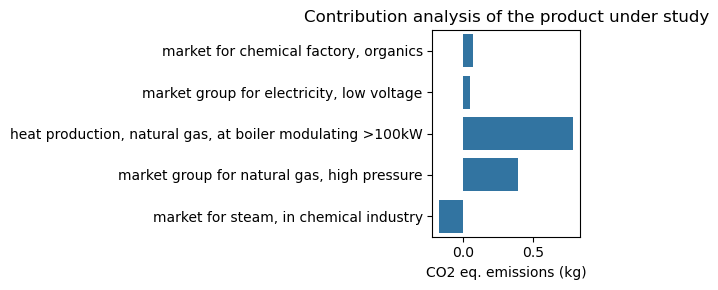

In [46]:
# First, we plot the contribution analysis for the brigthway ceramics production process
f, ax = plt.subplots(figsize=(6, 3))
sns.barplot(y='name', x='score', data=ammonia_lca_ca, ax=ax)
ax.set(
    title='Contribution analysis of the product under study',
    xlabel='CO2 eq. emissions (kg)',
    ylabel='')
plt.tight_layout()
plt.show()


### ⚖️ 8. Comparison

Only your creativity limits you in what you can do with the results from the impact assessment and contribution analysis. The data can also be stored in a combined dataframe (=combined_df) to then be shown in the same graph conveniently.

In [ ]:
# This is an example for combining two results in one table
combined_df = pd.concat([contribution_analysis_A.set_index('name').score,contribution_analysis_B.set_index('name').score],
                        keys=['ceramics_bw','ceramics_ei'],
                        names=['activity','contributor'])
combined_df

activity     contributor                                         
ceramics_bw  market for kaolin                                       0.145070
             market for feldspar                                     0.015081
             market group for electricity, high voltage              0.240714
             market group for natural gas, high pressure             0.282982
             packaging glass factory construction                    0.031445
ceramics_ei  ceramic factory construction                            0.096369
             market for electricity, medium voltage                  0.188177
             market for heat, district or industrial, natural gas    2.730413
             market for kaolin                                       0.111534
Name: score, dtype: float64

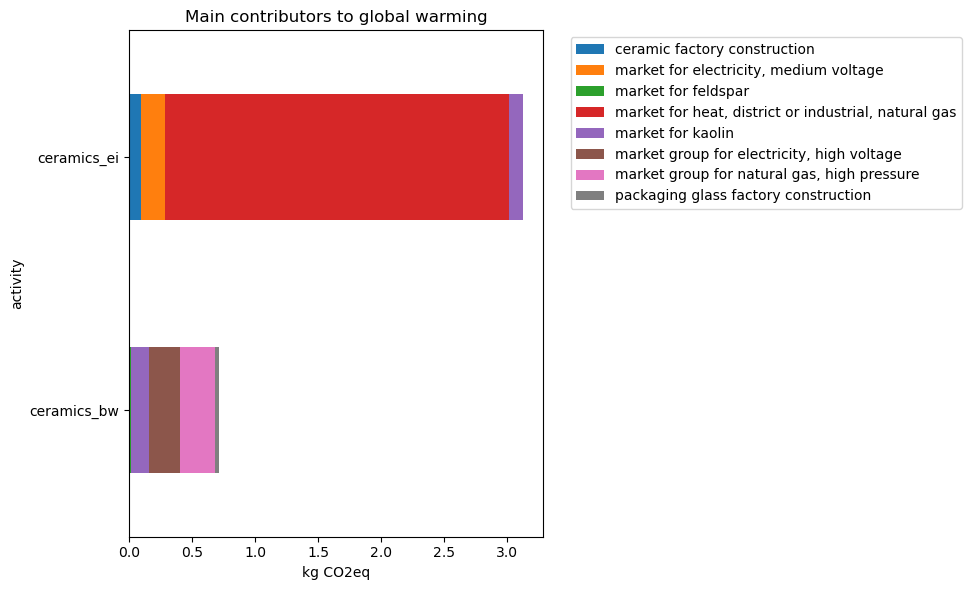

In [32]:
ax = combined_df.unstack().plot.barh(
    stacked=True,
    title='Main contributors to global warming',
    xlabel='kg CO2eq',
    figsize=(10,6)
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # moves legend outside
plt.tight_layout()
plt.show()